In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "../") # don't do this.
%matplotlib inline

import velociraptor

sources = velociraptor.load_gaia_sources("../data/rv-all.fits")
data_dict, idx = velociraptor.prepare_data(S=1e4, **sources)

init_dict = dict(theta=0.5,
    mu_coefficients=[2.1465e-05, 1.4585e+02, 2.0827e+11, 7.7332e-08, 5.8626e+00],
    sigma_coefficients=[7.4405e-04, 3.9762e-01, 1.7293e+11, 4.1103e-04, 5.9489e+00]
)

/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
../velociraptor.py:35: RuntimeWarning: invalid value encountered in log10
  + 5 * np.log10(sources["parallax"]/100.0)


In [2]:
theta = tf.clip_by_value(tf.Variable(0.5, dtype=tf.float64), 0, 1)
mu_coefficients = tf.clip_by_value(
    tf.Variable(np.atleast_2d(init_dict["mu_coefficients"]), dtype=tf.float64),
    0, np.inf)
sigma_coefficients = tf.clip_by_value(
    tf.Variable(np.atleast_2d(init_dict["sigma_coefficients"]), dtype=tf.float64),
    0, np.inf)

mu = tf.matmul(mu_coefficients, data_dict["design_matrix"].T)
ivar = tf.matmul(sigma_coefficients, data_dict["design_matrix"].T)**-2

log_p_s = tf.log(1.0 - theta) \
        - 0.5 * np.log(2 * np.pi) + 0.5 * tf.log(ivar) \
        - 0.5 * (data_dict["rv_variance"] - mu)**2 * ivar

log_p_b = tf.log(theta) \
        - np.log(np.max(data_dict["rv_variance"])) * np.ones((1, data_dict["N"]))

log_prob = tf.reduce_sum(tf.reduce_logsumexp(tf.concat([log_p_s, log_p_b], 0), 0))

In [3]:
tolerance = 1e-6
learning_rate = 1e-3
max_iterations = 100000

training_step = tf.train.AdamOptimizer(learning_rate).minimize(-log_prob)

cost_history = np.empty(shape=[1],dtype=float)

In [4]:
with tf.Session() as session:
    session = tf.Session()
    session.run(tf.global_variables_initializer())

    print("Initial log prob: {0}".format(session.run(log_prob)))
    print("Initial gradient: {0}".format(
        session.run(tf.gradients(log_prob, 
                                [theta, mu_coefficients, sigma_coefficients]))))

    for iteration in range(max_iterations):
        session.run(training_step)
        cost_history = np.append(cost_history, session.run(log_prob))
        
        if iteration % 1000 < 1:
            print(iteration, cost_history[-1], session.run(theta))
        
        if np.abs(np.diff(cost_history[-2:])) < tolerance:
            break

    theta_value = session.run(theta)
    mu_coefficients_value = session.run(mu_coefficients)
    sigma_coefficients_value = session.run(sigma_coefficients)


Initial log prob: -53428.141043139636
Initial gradient: [-13565.623649522307, array([[-8.64751323e+01, -1.82355052e-04, -9.84648572e-10,
        -4.80992815e+01, -9.34671405e+00]]), array([[-1.35529300e+02, -5.54319181e-04, -2.31966095e-09,
        -1.04270831e+02, -6.00516756e+01]])]
0 -53414.380196414844 0.49899999995252586
1000 -50738.25275680636 0.14123911383958843
2000 -50731.54427557549 0.13781589090020419
3000 -50731.098023872815 0.1368543226858839


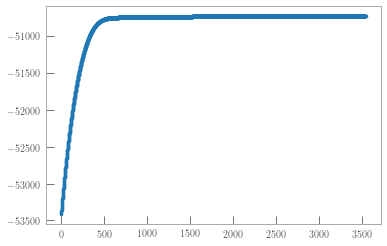

In [5]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(cost_history[1:])

In [8]:
phot_rp_mean_flux = np.logspace(np.log10(np.nanmin(sources["phot_rp_mean_flux"])),
                                np.log10(np.nanmax(sources["phot_rp_mean_flux"])),
                                100)

faux_dm = velociraptor._rvf_design_matrix(phot_rp_mean_flux=phot_rp_mean_flux,
                                          bp_rp=np.nanmean(sources["bp_rp"]) * np.ones(100))
mu = np.dot(mu_coefficients_value, faux_dm)[0]
sigma = np.dot(sigma_coefficients_value, faux_dm)[0]


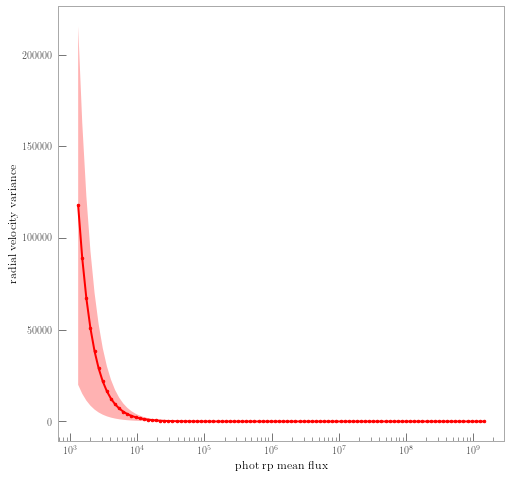

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(phot_rp_mean_flux, mu, c='r', lw=2)
ax.fill_between(phot_rp_mean_flux,
                mu - sigma, mu + sigma,
                facecolor="r", alpha=0.3, edgecolor="none")
ax.semilogx()
ax.set_xlabel(r"\textrm{phot rp mean flux}")
ax.set_ylabel(r"\textrm{radial velocity variance}")

In [14]:
# Construct model for hemcee

class TensorFlowModel(object):
    
    def __init__(self, target, variable_list, feed_dict=None, session=None):
        self.target = target
        self.variable_list = variable_list
        self.grad_target = tf.gradients(self.target, self.variable_list)
        self.feed_dict = dict() if feed_dict is None else feed_dict
        self._session = session
    
    @property
    def session(self):
        if self._session is None:
            return tf.get_default_session()
        return self._session

    def value(self, vector):
        feed_dict = self.vector_to_feed_dict(vector)
        return self.session.run(self.target, feed_dict=feed_dict)
    
    def gradient(self, vector):
        feed_dict = self.vector_to_feed_dict(vector)
        return np.concatenate([np.reshape(g, s) \
            for g, s in zip(
                self.sizes,
                self.session.run(self.grad_target, feed_dict=feed_dict))
        ])

    def setup(self, session=None):
        if session is not None:
            self._session = session
        values = self.session.run(self.variable_list)
        self.sizes = [np.size(v) for v in values]
        self.shapes = [np.shape(v) for v in values]
    
    def vector_to_feed_dict(self, vector):
        i = 0
        fd = dict(self.feed_dict)
        for var, size, shape \
        in zip(self.variable_list, self.sizes, self.shapes):
            fd[var] = np.reshape(vector[i:i+size], shape)
            i += size
        return fd
    
    def feed_dict_to_vector(self, feed_dict):
        return np.concatenate([
            np.reshape(feed_dict[v], s)
            for v, s in zip(self.variable_list, self.sizes)])

    def current_vector(self):
        values = self.session.run(self.variable_list)
        return np.concatenate([
            np.reshape(v, s)
            for v, s in zip(values, self.sizes)])